# Hotspot propensity observed and expected from Fig 3E

In [1]:
import os
from collections import defaultdict
import json

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from scipy.stats import entropy

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [3]:
data_dir = '../../../data'

In [4]:
sigs_color = {
'SBS1': '#1e79baff',
 'SBS2': '#ff9896ff',
 'SBS3': '#f6c200ff', 
 'SBS4': '#00a572ff', 
 'SBS5': '#7ebdeaff',
 'SBS7a': '#8c564bff', 
 'SBS7b': '#c49c94ff',
 'SBS8': '#3dbe3dff',
 'SBS13': '#d62728ff',
 'SBS17a': '#ffbb78ff',
 'SBS17b': '#ff8921ff', 
 'SBS18': '#9467bdff',
 'SBS40': '#c2e0f5ff',
 'SBS93': '#c5b0d5ff',
}

In [5]:
signatures_to_plot = list(sigs_color.keys())

### Load data

Input data corresponds to a table containing observed hotspot propensity calculations using 100 samples and 100-300 mutations per sample for 1000 iterations and a JSON file containing expected (theoretical) hotspot propensity. 

This expected was computed using the model of homogeneous distribution of trinucleotide-specific mutation rates with 300 mutations/sample and 100 samples across mappable megabases. 

In [6]:
# Observed hotspot propensity
propensity_f = f'{data_dir}/hotspot_propensity_1000iter_100samples_100-300muts.txt.gz'
propensity_df = pd.read_csv(propensity_f, sep='\t', header=0)
propensity_df.head()

,ITER,N_SAMPLES,TOTAL_HOTSPOTS,TOTAL_HOTSPOTS_UNIQPOS,TOTAL_MUTS,CTYPE,SIGNATURE
0,BLADDER_URI_iter_0_SBS2,100,0,0,10000,BLADDER_URI,SBS2
1,BLADDER_URI_iter_1_SBS2,100,1,1,10000,BLADDER_URI,SBS2
2,BLADDER_URI_iter_2_SBS2,100,0,0,10000,BLADDER_URI,SBS2
3,BLADDER_URI_iter_3_SBS2,100,2,2,10000,BLADDER_URI,SBS2
4,BLADDER_URI_iter_4_SBS2,100,2,2,10000,BLADDER_URI,SBS2


In [7]:
len(propensity_df)

279000

In [8]:
# Expected hotspot propensity
theoretical_propensity_f = f'{data_dir}/expected_hotspot_propensity/expected_hotspots_genomewide_disallowed.json'
with open(theoretical_propensity_f, 'r') as fd: 
    theoretical_propensity_data = json.load(fd)

In [9]:
# Reformat into a dictionary for easy access
theoretical_propensity_d = defaultdict(lambda: defaultdict(dict))
for element in theoretical_propensity_data: 
    muts, sig, samples, hotspots = element
    if str(samples)[-2] == '0': 
        theoretical_propensity_d[muts][sig][samples] = hotspots

### Compute observed hotspot propensity per signature

In [10]:
# Use only subsamplings with 300 mutations per sample across 100 samples (= 30000 total mutations)
subset = propensity_df.loc[propensity_df['TOTAL_MUTS'] == 30000].copy()
subset.sort_values(by='TOTAL_HOTSPOTS_UNIQPOS', ascending=False, inplace=True)
subset.head()

,ITER,N_SAMPLES,TOTAL_HOTSPOTS,TOTAL_HOTSPOTS_UNIQPOS,TOTAL_MUTS,CTYPE,SIGNATURE
259640,COADREAD_iter_640_SBS17b,100,129,129,30000,COADREAD,SBS17b
259565,COADREAD_iter_565_SBS17b,100,120,120,30000,COADREAD,SBS17b
259916,COADREAD_iter_916_SBS17b,100,119,119,30000,COADREAD,SBS17b
259824,COADREAD_iter_824_SBS17b,100,119,119,30000,COADREAD,SBS17b
259425,COADREAD_iter_425_SBS17b,100,119,119,30000,COADREAD,SBS17b


In [11]:
observed = dict()
data_to_sort = dict()
for signature, data in subset.groupby('SIGNATURE'): 
    median = np.median(data['TOTAL_HOTSPOTS_UNIQPOS'])
    first_quartile = np.percentile(data['TOTAL_HOTSPOTS_UNIQPOS'], 25)
    third_quartile = np.percentile(data['TOTAL_HOTSPOTS_UNIQPOS'], 75)
    observed[signature] = (median, first_quartile, third_quartile)
    data_to_sort[signature] = np.mean(data['TOTAL_HOTSPOTS_UNIQPOS'])
observed

{'SBS1': (39.0, 34.0, 44.0),
 'SBS13': (4.0, 2.0, 5.0),
 'SBS17a': (72.0, 62.0, 81.0),
 'SBS17b': (78.0, 69.0, 89.0),
 'SBS18': (7.0, 5.0, 8.0),
 'SBS2': (6.0, 4.0, 7.0),
 'SBS3': (1.0, 0.0, 2.0),
 'SBS4': (1.0, 0.0, 2.0),
 'SBS40': (1.0, 0.0, 2.0),
 'SBS5': (2.0, 1.0, 3.0),
 'SBS7a': (7.0, 6.0, 9.0),
 'SBS7b': (3.5, 2.0, 5.0),
 'SBS8': (6.0, 4.0, 8.0),
 'SBS93': (6.0, 5.0, 8.0)}

### Select parameters for expected hotspot propensity

In [12]:
# Select parameters
sample_muts = 300 
sample_size = 100
expected = {}
for signature, data in theoretical_propensity_d[sample_muts].items(): 
    if signature in signatures_to_plot: 
        expected[signature] = data[sample_size]
expected

{'SBS8': 0.17446386162369595,
 'SBS5': 0.1426547362630986,
 'SBS3': 0.09395065238712713,
 'SBS7a': 1.5768101628022724,
 'SBS17b': 1.8091686011195667,
 'SBS40': 0.09409000328332445,
 'SBS2': 2.244392562753391,
 'SBS93': 0.16100825597126936,
 'SBS18': 0.3836918517122858,
 'SBS4': 0.29589774792217993,
 'SBS7b': 1.0794757680081797,
 'SBS17a': 1.2788436883547256,
 'SBS1': 11.841720844099429,
 'SBS13': 1.3417561075896642}

In [13]:
max(expected.values())

11.841720844099429

In [14]:
fcs = []
for signature in expected.keys(): 
    fc = expected['SBS1'] / expected[signature]
    print(signature, fc)
    if signature != 'SBS1': 
        fcs.append(fc)
print(min(fcs), max(fcs))

SBS8 67.8749211091122
SBS5 83.00965782348582
SBS3 126.04192246909773
SBS7a 7.509921690924786
SBS17b 6.545393744270945
SBS40 125.85524955761304
SBS2 5.2761361985499375
SBS93 73.54728968812934
SBS18 30.862580978078814
SBS4 40.01963829482663
SBS7b 10.969881117340375
SBS17a 9.259709338937421
SBS1 1.0
SBS13 8.825538991115115
5.2761361985499375 126.04192246909773


### Compute observed vs expected hotspot propensity fold change

In [15]:
fold_change = {}
for signature, obs in observed.items(): 
    obs = obs[0]
    exp = expected[signature]
    fc = obs/exp
    fold_change[signature] = fc
fold_change

{'SBS1': 3.2934402451678446,
 'SBS13': 2.9811677229370805,
 'SBS17a': 56.30086042230099,
 'SBS17b': 43.113726355703555,
 'SBS18': 18.24380676514601,
 'SBS2': 2.6733291223524995,
 'SBS3': 10.643885642001326,
 'SBS4': 3.379545829672879,
 'SBS40': 10.628121639966292,
 'SBS5': 14.019863990434873,
 'SBS7a': 4.439342265247551,
 'SBS7b': 3.242314560203707,
 'SBS8': 34.39107643359117,
 'SBS93': 37.26516981260049}

In [16]:
max(fold_change.values())

56.30086042230099

## Panel 3E

In [17]:
# Sort signatures according to their mean observed hotspot propensity
sorted_sigs = [i[0] for i in sorted(data_to_sort.items(), key=lambda x: x[1], reverse=True)]

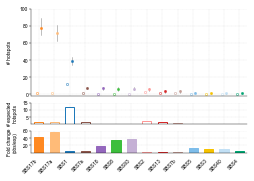

In [18]:
plt.rc('axes', edgecolor='black')
xmin = 0.5
xmax = 14.5
fig, ax = plt.subplots(
    3, 
    sharex='col', 
    figsize=(3.75, 2.5), 
     gridspec_kw={'height_ratios': [1, 0.25, 0.25]}
) 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.15)

## SUBPLOT 0 
axis_key = 0
sorted_sigs_top = sorted_sigs
sep = 0.15
for i, signature in enumerate(sorted_sigs_top, 1):  
    exp = expected[signature]
    obs, error_min, error_max = observed[signature]
    error_min = 0 if error_min < 0 else error_min
    ax[axis_key].plot([i+sep, i+sep], [error_min, error_max], ls='-', lw=0.5, c='grey', zorder=1)
    ax[axis_key].scatter(i+sep, obs, color=sigs_color[signature], alpha=1, marker='o', s=5, lw=0.5, zorder=3)
    ax[axis_key].scatter(i-sep, exp, color='white', marker='o', s=5, lw=0.5, edgecolor=sigs_color[signature])
ax[axis_key].set_xlim(xmin, xmax)
ax[axis_key].set_ylim(-2, 100)
ax[axis_key].set_yticks([0, 20, 40, 60, 80, 100])
ax[axis_key].set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=5)

## SUBPLOT 1 
axis_key = 1
xdata = []
ydata = []
colors = []
for i, signature in enumerate(sorted_sigs_top, 1):
    xdata += [i]
    ydata += [expected[signature]]
    colors += [sigs_color[signature]]
ax[axis_key].bar(xdata, ydata, width=0.60, color=['white']*len(xdata), edgecolor=colors)
ax[axis_key].set_ylim(0, 15)
ax[axis_key].set_yticks([5, 10, 15])
ax[axis_key].set_yticklabels([5, 10, 15])
ax[axis_key].set_xlim(xmin, xmax)

## SUBPLOT 2 
axis_key = 2
xdata = []
ydata = []
colors = []
for i, signature in enumerate(sorted_sigs_top, 1):
    xdata += [i]
    fc = fold_change[signature]
    ydata += [fc]
    colors += [sigs_color[signature]]
ax[axis_key].bar(xdata, ydata, width=0.60, color=colors, edgecolor=colors)
ax[axis_key].set_ylim(0, 60)
yticks = [20, 40, 60]
ax[axis_key].set_yticks(yticks)
ax[axis_key].set_yticklabels(yticks, fontsize=5)
ax[axis_key].set_xlim(xmin, xmax)

########### X axis
ax[axis_key].set_xticks(list(range(1, len(sorted_sigs) + 1)))
ax[axis_key].set_xticklabels(sorted_sigs, fontsize=6, rotation=45, ha='right')

########## Y axis
ylabels_dict = {
    0: '# hotspots', 
    1: '# expected\nhotspots',
    2: 'Fold change\n(obs/exp)'
}

for key, value in ylabels_dict.items(): 
    ax[key].set_axisbelow(True)
    ax[key].set_ylabel(value, fontsize=5, rotation=90, labelpad=10, va='center')
    ax[key].grid(color='lightgrey', linestyle='--', linewidth=0.25)
    for tick in ax[key].yaxis.get_major_ticks():
        tick.label.set_fontsize(5) 
    for tick in ax[key].xaxis.get_major_ticks():
            tick.label.set_fontsize(5) 
            
    for location in ['top', 'bottom', 'left', 'right']:
        ax[key].spines[location].set_linewidth(0.4)
        
    ax[key].tick_params(axis = "x", which = "both", bottom=False)
    ax[key].tick_params(axis = "y", which = "both", left=False)
    
    ax[key].tick_params(axis='both', which='major', pad=1) 
    ax[key].spines['right'].set_visible(False)
    ax[key].spines['top'].set_visible(False)
    
    ax[key].tick_params(axis = "x", which = "both", bottom=False)
    ax[key].tick_params(axis = "y", which = "both", left=True, width=0.4, length=2)

for extension in ['png']: 
    output = f'./fig_3E.{extension}'
    plt.savefig(output, bbox_inches='tight', dpi=350)